In [4]:
import sys
sys.path.append('/home/flowers/work/OpenELM')
import pickle
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from openelm.environments.p3.p3 import P3ProbSolResult
import json
import torch
import copy
def pass_at_k(n, c, k):
    """:param n: total number of samples    :param c: number of correct samples     :param k: k in pass@k"""
    assert n >= k
    if n - c < k:
        return 1.0
    return 1.0 - np.prod(1.0 - k / np.arange(n - c + 1, n + 1))

snapshot_path= "/home/flowers/work/OpenELM/logs/elm/24-02-05_15:39/step_130/puzzles_test.json"
with open(snapshot_path, "r") as f:
    genomes = json.load(f)

original_losses=np.array(genomes[0]["original_losses"])


def compute_PP(puz,perplexity=True,delta=True,k=-1):
    fin_loss = np.array(puz["final_losses"])
    finloss=copy.deepcopy(fin_loss)
    orig_loss = copy.deepcopy(original_losses)
    if k!=-1:
        idx_fin_loss = np.argsort(fin_loss)[:k]
        finloss=finloss[idx_fin_loss]
        orig_loss = orig_loss[idx_fin_loss]
    # (torch.exp(puz["final_losses"])-torch.exp(torch.tensor(original_losses))).mean(1)
    if perplexity:
        finloss = np.exp(finloss)
        orig_loss= np.exp(orig_loss)
    if delta:
        return (finloss - orig_loss).mean()
    else:
        return finloss.mean()



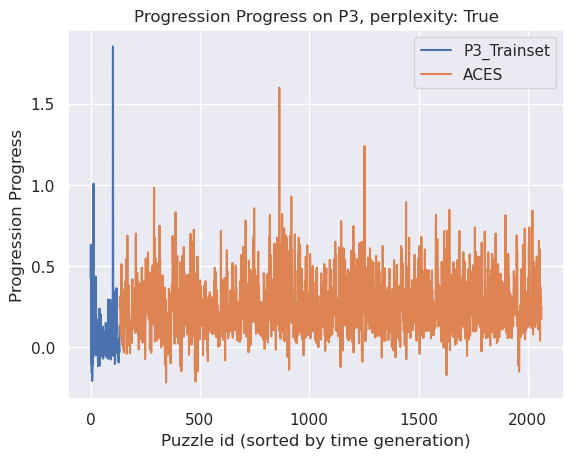

In [5]:
k=-1
perplexity=True
delta=True

for perplexity in [True]:
    list_fitness_train=[]
    list_fitness=[]
    list_idx_gen=[puz["idx_generation"] for puz in genomes]
    for puz in genomes:

        if "fitnessPP" in puz:
            if puz["idx_generation"]==-1:
                list_fitness_train.append(compute_PP(puz,perplexity=perplexity,delta=delta,k=k))#puz["fitnessPP"])
            else:
                list_fitness.append(compute_PP(puz,perplexity=perplexity,delta=delta,k=k))#puz["fitnessPP"])
    x_train=np.arange(len(list_fitness_train))
    x=np.arange(len(x_train),len(list_fitness)+len(x_train))
    plt.plot(x_train,list_fitness_train)
    plt.plot(x,list_fitness)
    plt.legend(["P3_Trainset","ACES"])
    plt.xlabel("Puzzle id (sorted by time generation)")
    plt.ylabel("Progression Progress")
    plt.title("Progression Progress on P3, perplexity: "+str(perplexity))
    plt.show()


# Results of new ACES run


I launched an ACES run (130 generation ~ 2000 puzzles) with the new prompt to look for any problem especially concerning the previous problem in the computational shift from g to f.
First, it seems that the computational shift is no longer present (or rarely).
However, there are other problems. One of them is that sometimes the function f is similar to g. I didn't compute how often it happens but it can be problematic.

The problem is we want f the problem and g such as f(g(args),args) == True for preferably every possible args so the solution g generalizes to every args.
It means that unless the problem is asymmetrical in the sense that the solution (f) is easier (or harder) to find than (g), f should be similar to g. 
For example:
- solving sudoku is an asymmetrical problem, it's easy to verify a solution but harder to find a solution.
- check if factorial is implemented correctly is a symmetrical problem in P3 Framework, see below:

```python
def f(factorial: int, n=5) -> bool:
    def calc_factorial(n):
        if n == 0:
            return 1
        return n * calc_factorial(n - 1)
    
    return factorial == calc_factorial(n)

def g(n=5) -> int:
    def calc_factorial(n):
        if n == 0:
            return 1
        return n * calc_factorial(n - 1)
    return calc_factorial(n)

assert f(g()) == True
```
Note that this problem could be asymmetrical if we could have a variant of the P3 framework that gives the function of g to f (and not its results, so we just verify `assert f(g,args)` or just `assert f(g)`)
In this variant, we could just check the correctness of g with:

```python
def f(factorial):
    try:
        n=5
        assert factorial(n)/factorial(n-1)==n
        assert factorial(0)==1
        return True
    except:
        return False
def g...
assert f(g) == True
```

Besides this, I should also check the trainset because there are puzzles like that in the P3 trainset and I should probably remove them:
```python
Puzzle description: The puzzle involves a function f that takes a string and checks if the string can be transformed into a target string using a specific permutation. The solution function g generates a string that can be transformed into the target string using the inverse permutation. The assertion at the end checks if applying g to f results in True.

def f(s: str, perm='qwertyuiopasdfghjklzxcvbnm', target='mujychenyzo') -> bool:
    return ''.join((perm[(perm.index(c) + 1) % len(perm)] if c in perm else c for c in s)) == target
def g(perm = 'qwertyuiopasdfghjklzxcvbnm', target = 'mujychenyzo'):
    return "".join((perm[(perm.index(c) - 1) % len(perm)] if c in perm else c) for c in target)
assert f(g()) == True
```

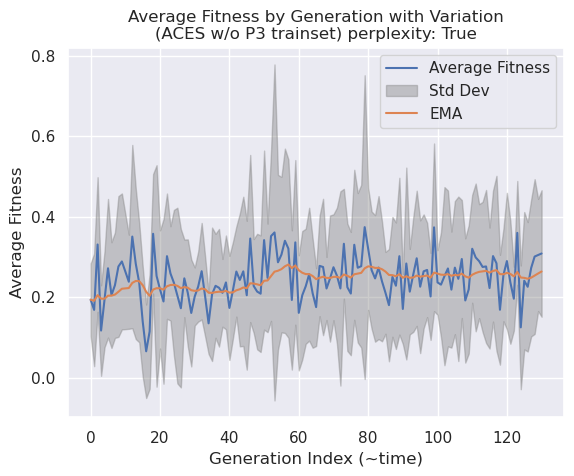

In [6]:
k=-1
perplexity=True
delta=True

for perplexity in [True]:

    list_fitness = []  # This will be populated with fitness values
    list_idx_gen = [puz["idx_generation"] for puz in genomes]  # Generation indices

    # Placeholder for genomes.archive processing to fill list_fitness
    for puz in genomes:
        if "fitnessPP" in puz:
            list_fitness.append(compute_PP(puz,perplexity=perplexity,delta=delta,k=k))

    # Map each generation index to its fitness values
    fitness_per_generation = defaultdict(list)
    for idx, fitness in zip(list_idx_gen, list_fitness):
        fitness_per_generation[idx].append(fitness)

    # Calculate the average fitness and standard deviation per generation
    avg_fitness_per_gen = {}
    std_dev_fitness_per_gen = {}
    for gen, fitnesses in fitness_per_generation.items():
        avg_fitness_per_gen[gen] = np.mean(fitnesses)
        std_dev_fitness_per_gen[gen] = np.std(fitnesses)

    # Sort the generations to plot them in order
    sorted_gen_indices = sorted(avg_fitness_per_gen.keys())
    sorted_avg_fitness = [avg_fitness_per_gen[gen] for gen in sorted_gen_indices]
    sorted_std_dev_fitness = [std_dev_fitness_per_gen[gen] for gen in sorted_gen_indices]

    # Calculate the upper and lower bounds for the fill
    upper_bound = [avg + std for avg, std in zip(sorted_avg_fitness, sorted_std_dev_fitness)]
    lower_bound = [avg - std for avg, std in zip(sorted_avg_fitness, sorted_std_dev_fitness)]

    # Plotting
    first_idx=1

    plt.plot(sorted_gen_indices[first_idx:], sorted_avg_fitness[first_idx:], label='Average Fitness')
    plt.fill_between(sorted_gen_indices[first_idx:], lower_bound[first_idx:], upper_bound[first_idx:], color='gray', alpha=0.4, label='Std Dev')
    #plot ema
    ema = [sorted_avg_fitness[first_idx]]
    alpha = 0.1
    for i in range(1, len(sorted_avg_fitness[first_idx:])):
        ema.append(alpha * sorted_avg_fitness[first_idx:][i] + (1 - alpha) * ema[i - 1])
    plt.plot(sorted_gen_indices[first_idx:], ema, label='EMA')
    plt.xlabel("Generation Index (~time)")
    plt.ylabel("Average Fitness")
    plt.title("Average Fitness by Generation with Variation\n(ACES w/o P3 trainset) perplexity: "+str(perplexity))
    plt.legend()
    plt.show()


## Progression Progress (c.f. [@Laetitia post](https://openlab-flowers.inria.fr/t/compression-progress-in-p3/2923))

To analyze the ACES archive I tried to compute the PP of each puzzle.

[insert figure above]

There is a relatively slow trend downward, but it is relatively noisy so I don't know if it is really meaningful.

## pass@k
In addition, I also computed the difficulty (pass_k) of each puzzle with [deepseek-coder-1.3b-instruct](https://huggingface.co/deepseek-ai/deepseek-coder-1.3b-instruct) to maybe find any potential correlation. And to look for the evolution of difficulty across time.

[insert figure 1 below]
In this first plot the evolution of the difficulty is stable (see Exponential Moving Average) and it is similar to the difficulty of the trainset.
note: lower is harder pass_1 = 0 -> unsolved, 0.2 -> solved in 1 attempt out of 5, ..., 1. -> solved in 5 attempts out of 5.

The distribution is relatively similar between the P3 trainset and ACES puzzles: 
[insert figure 2 below ]

## Correlation PP and pass@k
Surprisingly, I don't see any correlation between those two... 
 
[insert figure 3 below] 


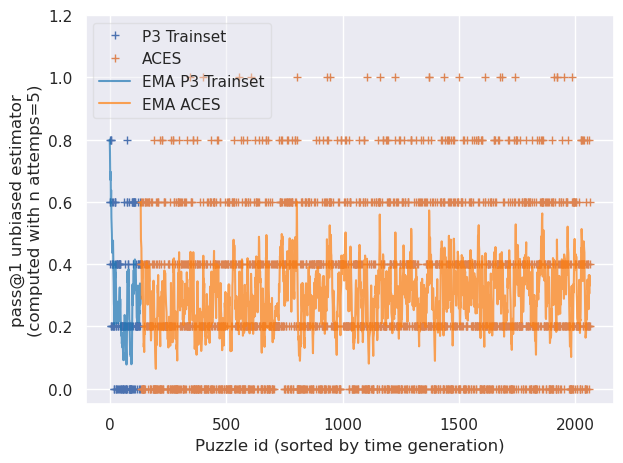

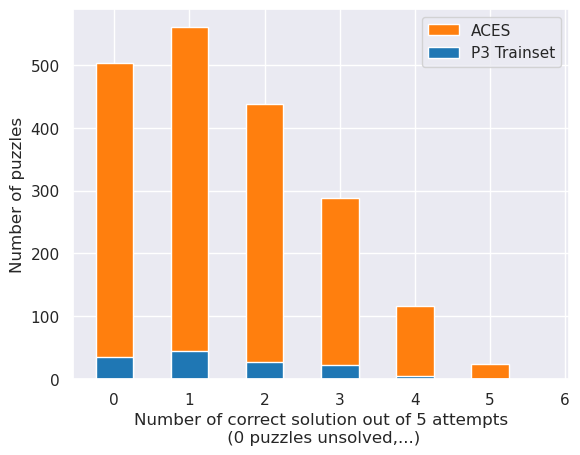

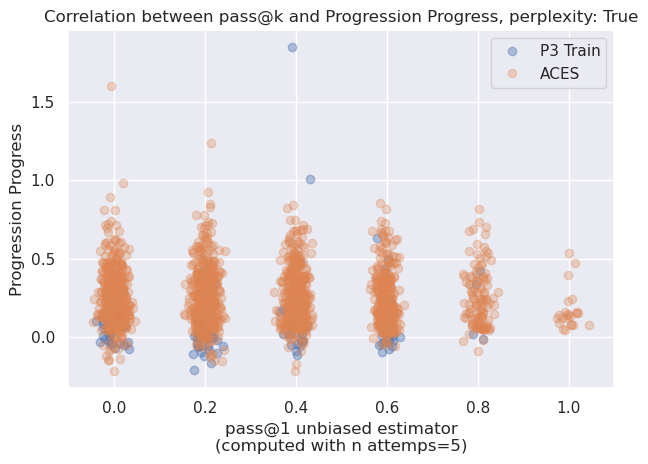

In [7]:
perplexity = True
delta = True
k=-1
list_fitness=[]
list_passk=[]
list_correct=[]
list_fitness_train=[]
list_passk_train=[]
list_correct_train=[]
n=5
c=1
pas_k=1
for puz in genomes:
    if puz["idx_generation"]!=-1:
        if "fitnessPP" in puz and "n_correct" in puz:
            list_fitness.append(compute_PP(puz,perplexity=perplexity,delta=delta,k=k))
            list_passk.append(pass_at_k(n, puz["n_correct"], pas_k))#puz["n_correct"]/5)   
            list_correct.append(puz["n_correct"])
    else:
        if "fitnessPP" in puz and "n_correct" in puz:
            list_fitness_train.append(compute_PP(puz,perplexity=perplexity,delta=delta,k=k))
            list_passk_train.append(pass_at_k(n, puz["n_correct"], pas_k))
            list_correct_train.append(puz["n_correct"])
#plot pass@k sorted by time
x_train=np.arange(len(list_fitness_train))
x=np.arange(len(x_train),len(list_fitness)+len(x_train))
plt.plot(x_train,list_passk_train,'+',label="P3 Trainset")
plt.plot(x,list_passk,'+',label="ACES")
ema = [list_passk_train[0]]
alpha = 0.2
for i in range(1, len(list_passk_train)):
    ema.append(alpha * list_passk_train[i] + (1 - alpha) * ema[i - 1])
plt.plot(x_train, ema,label="EMA P3 Trainset",color="tab:blue",alpha=0.7)
ema = [list_passk[0]]
for i in range(1, len(list_passk)):
    ema.append(alpha * list_passk[i] + (1 - alpha) * ema[i - 1])
plt.plot(x, ema,label="EMA ACES",color="tab:orange",alpha=0.7)
plt.legend(fancybox=True, framealpha=0.4)
plt.ylim(top=1.2)
plt.xlabel("Puzzle id (sorted by time generation)")
plt.ylabel("pass@1 unbiased estimator\n(computed with n attemps=5)")
plt.tight_layout()
plt.show()

# plot pass@k distribution
bins = np.linspace(0,6, 7)-0.25
plt.hist(list_correct,bins=bins,align="mid",width=0.5,label="ACES",alpha=1,color="tab:orange")
plt.ylabel("Number of puzzles")
plt.xlabel("Number of correct solution out of 5 attempts\n (0 puzzles unsolved,...)")
plt.hist(list_correct_train,bins=bins,align="mid",width=0.5,label="P3 Trainset",alpha=1,color="tab:blue")
plt.ylabel("Number of puzzles")
plt.xlabel("Number of correct solution out of 5 attempts\n (0 puzzles unsolved,...)")
plt.legend()
plt.show()


# plot correlation between pass@k and fitness

list_passk_train=np.array(list_passk_train)
# add small noise to avoid overlap
list_passk_train+=np.random.normal(0, 0.015, len(list_passk_train))
list_passk=np.array(list_passk)
list_passk+=np.random.normal(0, 0.015, len(list_passk))
plt.plot(list_passk_train,list_fitness_train , 'o',alpha=0.4)
plt.plot(list_passk,list_fitness , 'o',alpha=0.3)
plt.legend(["P3 Train", "ACES"])
plt.xlabel("pass@1 unbiased estimator\n(computed with n attemps=5)")
plt.ylabel("Progression Progress")
plt.title("Correlation between pass@k and Progression Progress, perplexity: "+str(perplexity))
plt.tight_layout()
plt.show()



In [8]:
# np.mean(list_passk_train), np.mean(list_passk)
list_k=[i for i in range(1,6)]

print("pass_k train")
pass_k_train={}
for k in list_k:
    pass_k_train[f"pass_{k}"]=[]
for corr in list_correct_train:
    for k in list_k:
        pass_k_train[f"pass_{k}"].append(pass_at_k(n, corr, k))
for k in list_k:
    print(f"pass@{k} = {np.mean(pass_k_train[f'pass_{k}'])}")

print("========\npass_k ACES")
pass_k={}
for k in list_k:
    pass_k[f"pass_{k}"]=[]
for corr in list_correct:
    for k in list_k:
        pass_k[f"pass_{k}"].append(pass_at_k(n, corr, k))
for k in list_k:
    print(f"pass@{k} = {np.mean(pass_k[f'pass_{k}'])}")

pass_k train
pass@1 = 0.2721804511278195
pass@2 = 0.456390977443609
pass@3 = 0.5812030075187969
pass@4 = 0.6691729323308271
pass@5 = 0.7368421052631579
pass_k ACES
pass@1 = 0.29860176074572753
pass@2 = 0.4816675297773175
pass@3 = 0.6001035732780943
pass@4 = 0.6808907301916106
pass@5 = 0.7389953392024857


# test PP

In [9]:
import json
import matplotlib.pyplot as plt
import numpy as np  

snapshot_path= "/home/flowers/work/OpenELM/logs/elm/24-02-05_15:39/step_130/puzzles_test.json"
with open(snapshot_path, "r") as f:
    genomes = json.load(f)

# original_losses=genomes[0]["original_losses"]

## plot loss from trainset 

In [10]:
from openelm.environments.p3.p3 import P3ProbSol_Chat, P3ProbSol_Chat_PP
from openelm.mutation_model import PromptModel
from hydra import initialize, initialize_config_module, initialize_config_dir, compose
from omegaconf import OmegaConf
from key import OPENAI_API_KEY
import os
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY
with initialize(version_base="1.2"):
    cfg = compose(config_name="elmconfig",overrides=["env=P3ProbSolChatEnv_PP_ELM_NLP"]) # P3ProbSolChatEnv_PP_ELM_NLP
    # print(cfg)
config = OmegaConf.to_object(cfg)

cfg_generation: dict = {
            "temperature": 0.,
            "model": config.model.model_path,
        }
print(config.model.model_path)

#init P3 environment


mutation_model = PromptModel(config.model)
env = P3ProbSol_Chat_PP(config= config.env,
        mutation_model=mutation_model)


gpt-3.5-turbo-0125
 



none 





load embedding model:
ChatGPT
loading preprocessed trainset


100%|██████████| 133/133 [00:00<00:00, 2153831.78it/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/home/flowers/miniconda3/envs/codegpt/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


bsize 8
OptimizedModule(
  (_orig_mod): LlamaForCausalLM(
    (model): LlamaModel(
      (embed_tokens): Embedding(32256, 2048)
      (layers): ModuleList(
        (0-23): 24 x LlamaDecoderLayer(
          (self_attn): LlamaFlashAttention2(
            (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
            (k_proj): Linear(in_features=2048, out_features=2048, bias=False)
            (v_proj): Linear(in_features=2048, out_features=2048, bias=False)
            (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
            (rotary_emb): LlamaLinearScalingRotaryEmbedding()
          )
          (mlp): LlamaMLP(
            (gate_proj): Linear(in_features=2048, out_features=5504, bias=False)
            (up_proj): Linear(in_features=2048, out_features=5504, bias=False)
            (down_proj): Linear(in_features=5504, out_features=2048, bias=False)
            (act_fn): SiLU()
          )
          (input_layernorm): LlamaRMSNorm()
          (post_atte

/home/flowers/miniconda3/envs/codegpt/lib/python3.10/site-packages/torch/overrides.py:110: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  torch.has_cuda,
/home/flowers/miniconda3/envs/codegpt/lib/python3.10/site-packages/torch/overrides.py:111: UserWarning: 'has_cudnn' is deprecated, please use 'torch.backends.cudnn.is_available()'
  torch.has_cudnn,
/home/flowers/miniconda3/envs/codegpt/lib/python3.10/site-packages/torch/overrides.py:117: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  torch.has_mps,
/home/flowers/miniconda3/envs/codegpt/lib/python3.10/site-packages/torch/overrides.py:118: UserWarning: 'has_mkldnn' is deprecated, please use 'torch.backends.mkldnn.is_available()'
  torch.has_mkldnn,
[2024-02-12 11:27:36,370] torch._dynamo.convert_frame: [WARNING] torch._dynamo hit config.cache_size_limit (64)
[2024-02-12 11:27:36,370] torch._dynamo.convert_frame: [WARNING]    function: '<resume in _upad_input>' (/

original losses tensor([0.0529, 0.2955, 0.0947, 2.6444, 1.0933, 0.4004, 0.8378, 1.7219, 1.3408,
        0.7165, 0.0757, 0.8589, 0.4509, 1.1563, 0.7996, 1.1272, 1.9671, 0.5072,
        0.3160, 0.4601, 0.6307, 0.6661, 0.4435, 1.4670, 0.9260, 0.0562, 1.6237,
        1.0961, 0.8762, 0.8489, 0.0537, 0.7937, 0.3742, 1.5159, 0.1472, 0.3177,
        0.0208, 0.0534, 0.0498, 1.0200, 0.7332, 0.0594, 0.7058, 0.7266, 0.5441,
        0.7296, 1.3274, 0.5483, 0.4423, 0.4607, 0.6477, 1.0123, 1.5233, 0.5184,
        1.4590, 1.0245, 0.2467, 0.9399, 2.0055, 1.5379, 0.5525, 0.2189, 0.2951,
        0.4252, 0.1265, 0.2088, 0.7933, 0.9587, 0.6380, 0.8054, 0.6949, 0.8219,
        0.1142, 0.7783, 0.0761, 0.2869, 0.6934, 1.0585, 0.7089, 0.2632, 0.1905,
        0.1785, 0.6574, 0.6903, 0.5840, 0.2348, 0.4243, 1.0153, 0.6083, 1.3502,
        0.7672, 0.7306, 0.4025, 0.6472, 0.1107, 0.2054, 1.3460, 0.4251, 1.1632,
        1.0018, 0.6185, 0.9339, 0.6163, 0.6768, 0.2780, 0.6675, 0.3720, 0.3149,
        0.8388, 1.3808, 

In [33]:
def print_k_best(list_puz,values,k=5,print_=False):
    str_puz=""
    assert len(list_puz)==len(values)
    puzzle_loss_pairs = list(zip(list_puz,values))

    puzzle_loss_pairs_sorted = sorted(puzzle_loss_pairs, key=lambda x: x[1])
    lowest_loss_puzzles = puzzle_loss_pairs_sorted[:k]
    highest_loss_puzzles = puzzle_loss_pairs_sorted[-k:]
    str_puz+="\n============== lowest loss puzzles ====================\n"
    if print_:
        print("============== lowest loss puzzles ====================\n")
    for puzzle, loss in lowest_loss_puzzles:
        if print_:
            print(f"\nPP = {loss}")
            print(puzzle)
        str_puz+=f"\nPP = {loss}\n"
        str_puz+= puzzle
        str_puz+="\n----------\n"
    if print_:
        print("\n==================== \n")
        print("==============  highest loss puzzles ====================")
    str_puz+="\n==================== \n"
    str_puz+="==============  highest loss puzzles ===================="
    for puzzle, loss in highest_loss_puzzles:
        if print_:
            print(f"\nPP = {loss}")
            print(puzzle)
        str_puz+=f"\nPP = {loss}\n"
        str_puz+= puzzle
        str_puz+="\n----------\n"
    return str_puz


In [20]:
full_archive_puzzle=[puzzle_strs + "\n" +  sol_strs.split("\nassert")[0] for puzzle_strs, sol_strs in zip(env.archive_puzzle_strs, env.archive_sol_strs)]
full_archive_puzzle # list of str (puzzles)
original_losses # list of values associated to those puzzles
# plot k puzzles with highest and lowest loss   
print_k_best(full_archive_puzzle,original_losses,k=3)

============== lowest loss puzzles ====================


PP = 0.020815912634134293
def f(s: str, target="foobarbazwow", length=6):
    """Find a substring of the given length centered within the target string."""
    return target[(len(target) - length) // 2:(len(target) + length) // 2] == s
def g(target="foobarbazwow", length=6):
    return target[(len(target) - length) // 2:(len(target) + length) // 2]

PP = 0.04979050159454346
def f(s: str, word="silon"):
    """Capitalize the first letter of word"""
    for i in range(len(word)):
        if i == 0:
            if s[i] != word[i].upper():
                return False
        else:
            if s[i] != word[i]:
                return False
    return True
def g(word="silon"):
    return word[0].upper() + word[1:]

PP = 0.05293837562203407
def f(s: str):
    """Find a string that when concatenated onto 'Hello ' gives 'Hello world'."""
    return "Hello " + s == "Hello world"
def g():
    return "world"


==============  highest los

'\n============== lowest loss puzzles ====================\n\nPP = 0.020815912634134293\ndef f(s: str, target="foobarbazwow", length=6):\n    """Find a substring of the given length centered within the target string."""\n    return target[(len(target) - length) // 2:(len(target) + length) // 2] == s\ndef g(target="foobarbazwow", length=6):\n    return target[(len(target) - length) // 2:(len(target) + length) // 2]\nPP = 0.04979050159454346\ndef f(s: str, word="silon"):\n    """Capitalize the first letter of word"""\n    for i in range(len(word)):\n        if i == 0:\n            if s[i] != word[i].upper():\n                return False\n        else:\n            if s[i] != word[i]:\n                return False\n    return True\ndef g(word="silon"):\n    return word[0].upper() + word[1:]\nPP = 0.05293837562203407\ndef f(s: str):\n    """Find a string that when concatenated onto \'Hello \' gives \'Hello world\'."""\n    return "Hello " + s == "Hello world"\ndef g():\n    return "world"

## sanity test puzzle ref

# Sanity check Progression Progress

## **Reminder:**


 the Progression Progress is based on cross-entropy loss used for training language model.

From laetita post:
> Add a puzzle in the context when computing the loss on the solution (~ essentially measures how well a LLM can predicts the solution of a set of puzzle). In that case we compare the loss on solutions before adding the puzzle in context against another refernce puzzle. If the puzzle is helpful in context we should see the loss go down. 

To have an estimation of how good a puzzle is, we average the PP over multiple puzzles from the trainset (lower is better). 

Here we use the cross entropy loss over all token corresponding to the solution, given a sequence of N words, the loss can be calculated using the formula:
$\text{Cross Entropy Loss} = -\frac{1}{N} \sum_{i=1}^{N} \log(p(w_i|w_{i-1}, w_{i-2}, ..., w_1))$

Then instead of using directly the loss I am going to use Perplexity. It is a metric often used to evaluate language models. It is defined as the exponential of the Cross Entropy Loss:
$\text{Perplexity} = \exp\left(-\frac{1}{N} \sum_{i=1}^{N} \log(p(w_i|w_{i-1}, w_{i-2}, ..., w_1))\right)$

For example a puzzle with the lowest perplexity (with random puzzle as example not shown here):
```
 ========puzzle idx: 41 perplexity: 1.0746912956237793
def f(n: int, pairs=[[266519, 0], [548032, 32788], [612482, 632311], [465240, 376403], [123288, 475698], [962873, 439482], [193531, 258475], [747616, 319130], [592192, 824307], [508933, 296745], [411467, 566648], [905981, 19854], [805465, 657818], [802088, 325540], [127441, 1703553], [19150, 964316], [0, 199230]]):
    assert sum((p - m for (p, m) in pairs)) == 0, 'oo'
    tot = 0
    success = False
    for (p, m) in pairs:
        tot -= m
        tot += p
        assert tot <= n
        if tot == n:
            success = True
    return success
def g(pairs=[[266519, 0], [548032, 32788], [612482, 632311], [465240, 376403], [123288, 475698], [962873, 439482], [193531, 258475], [747616, 319130], [592192, 824307], [508933, 296745], [411467, 566648], [905981, 19854], [805465, 657818], [802088, 325540], [127441, 1703553], [19150, 964316], [0, 199230]]):
    tot = 0
    n = 0
    for (p, m) in pairs:
        tot += p - m
        if tot > n:
            n = tot
    return n
```
It has very low perplexity because most of the tokens of the solution are just copy and paste of args.

Finally, here to compute PP of given puzzle, We can just take the delta between the Perplexity with the given puzzle and the reference puzzle. 

Ref puzzle used here (need to recheck openlab to know how it was choosen):
```
def f(s: List[str]):
    """Find a list of 1000 distinct strings which each have more 'a's than 'b's and at least one 'b'."""
    return len(set(s)) == 1000 and all((x.count("a") > x.count("b")) and ('b' in x) for x in s)

def g():
    return ["a" * (i + 2) + "b" for i in range(1000)]
```
TL DR
$\text{PP(puzzle)} = \frac{1}{N} \sum_{i=1}^{N} \text{Perplexity}(\text{LLM}(\text{sol}_i|puzzle)) - \text{Perplexity}(\text{LLM}(\text{sol}_i|\text{puzzle}_\text{ref}))$
where $\text{sol}_i$ is from P3 trainset, here N ~ 140 puzzles

To have an intersting puzzle we want a low PP:
 - $\text{Perplexity}(\text{sol}_i|puzzle)$ should be low (solution is easy to predict given the puzzle)
 - $\text{Perplexity}(\text{sol}_i|\text{puzzle}_\text{ref})$ is the reference

First Problem:
When a puzzle we want to evaluate and puzzle_ref have equal perplexity (high or low) => PP is low and we can't separate bad and good puzzles
Second Problem:
If a puzzle have lot of args it has low perplexity => we should't compute perplexity on args (FIXED)

## Check reference puzzles



I want to check if Progession Progress (PP) seems to be ok -> puzzle with lower PP are more interesting.

First I want to check if reference puzzles are ok, so I plotted the Perplexity of averaged over all ACES generated puzzles (n=2064).


In [21]:
PP_=[]
PP_delta=[] 
PP_perplexity=[]
PP_delta_perplexity=[]
compute_PP(puz,perplexity=True,delta=True,k=-1)
list_puz=[]
for puz in genomes:
    if puz["idx_generation"]!=-1:
        list_puz.append(puz["description"][0]+"\n"+puz["program_str"])
        PP_.append(compute_PP(puz,perplexity=False,delta=False,k=-1))
        PP_delta.append(compute_PP(puz,perplexity=False,delta=True,k=-1))
        PP_perplexity.append(compute_PP(puz,perplexity=True,delta=False,k=-1))
        PP_delta_perplexity.append(compute_PP(puz,perplexity=True,delta=True,k=-1))


probably should easiest puzzle for ref instead of we are using rn

In [50]:
out=print_k_best(list_puz,PP_,k=10)
# save as txt
path_save = "/home/flowers/work/OpenELM/analysis_P3/quality/results/PP_CE.txt"
with open(path_save, "w") as f:
    f.write(out)


In [51]:
out= print_k_best(list_puz,PP_delta,k=10)
path_save = "/home/flowers/work/OpenELM/analysis_P3/quality/results/PP_CE_delta.txt"
with open(path_save, "w") as f:
    f.write(out)

In [52]:
out=print_k_best(list_puz,PP_perplexity,k=10)
path_save = "/home/flowers/work/OpenELM/analysis_P3/quality/results/PP_perplexity.txt"
with open(path_save, "w") as f:
    f.write(out)

In [53]:
out=print_k_best(list_puz,PP_delta_perplexity,k=10)
path_save = "/home/flowers/work/OpenELM/analysis_P3/quality/results/PP_delta_perplexity.txt"
with open(path_save, "w") as f:
    f.write(out)